In [4]:
# Normal imports for everybody
import keras
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [5]:
t=time.time()
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')
print(time.time()-t)
print(np.shape(X),np.shape(Y))

95.77709078788757
(24571, 5000) (24571, 500)


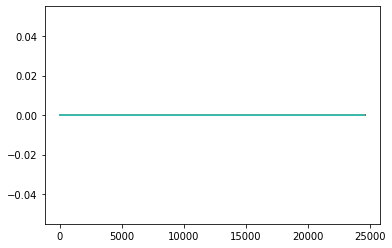

[-0.82188075  3.35414138  0.77480965 -0.57932854] [0.17953081 0.08178025 0.12285084 0.04704531]


In [6]:
X=np.reshape(X,(-1,1000,5))

plt.plot(X[:,:,4])
plt.show()
X=X[:,:,:4]

eps=1e-15

X=X*(X>0)
X=np.log10(X+eps)

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(4):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]

#X=np.reshape(X,(-1,1000*4))

Y=np.log10(Y*1e20)

#Min_Max Scaling of Y
y_min=np.min(Y)
Y=Y-y_min
y_max=np.max(Y)
Y=Y/y_max


In [7]:
model = keras.Sequential()
model.add(Conv1D(filters = 16, kernel_size = 6, activation='relu', input_shape = (1000,4)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=4))

model.add(Conv1D(filters = 16, kernel_size = 6, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.25))

#model.add(Flatten())

model.add(Bidirectional(LSTM(500)))
model.add(Dense(500, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam') #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 995, 16)           400       
_________________________________________________________________
batch_normalization_5 (Batch (None, 995, 16)           64        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 248, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 243, 16)           1552      
_________________________________________________________________
batch_normalization_6 (Batch (None, 243, 16)           64        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 121, 16)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 121, 16)           0         
__________

In [8]:
history = model.fit(X, Y, batch_size=256, epochs=10, validation_split=0.15,
                    callbacks=[keras.callbacks.TerminateOnNaN()], shuffle=False)

W0701 21:10:09.798964 140193084229376 deprecation.py:323] From /home/vinit/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0701 21:10:10.856390 140193084229376 deprecation_wrapper.py:119] From /home/vinit/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 20885 samples, validate on 3686 samples
Epoch 1/10
20885/20885 [==============================] - 318s 15ms/step - loss: 0.0096 - val_loss: 0.0019
Epoch 2/10
20885/20885 [==============================] - 325s 16ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/10
20885/20885 [==============================] - 306s 15ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/10
20885/20885 [==============================] - 305s 15ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/10
20885/20885 [==============================] - 304s 15ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/10
20885/20885 [==============================] - 303s 15ms/step - loss: 0.0011 - val_loss: 9.4344e-04
Epoch 7/10
20885/20885 [==============================] - 303s 15ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/10
20885/20885 [==============================] - 303s 15ms/step - loss: 0.0010 - val_loss: 9.3502e-04
Epoch 9/10
20885/20885 [==============================] - 304s 15ms/step - loss: 9.8545

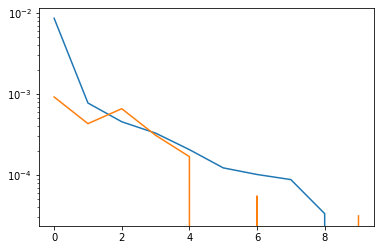

In [20]:
plt.semilogy(history.history['loss']-history.history['loss'][-1])
plt.semilogy(history.history['val_loss']-history.history['loss'][-1])

In [10]:
import scipy.ndimage.filters as sp
from scipy.special import softmax
import importlib
import bolsig
importlib.reload(bolsig)
from bolsig import bolsig

In [15]:
n=10
y_hat=model.predict(X[:100,:,:])
#y_hat=sp.gaussian_filter1d(y_hat,20)

|(1000, 4)


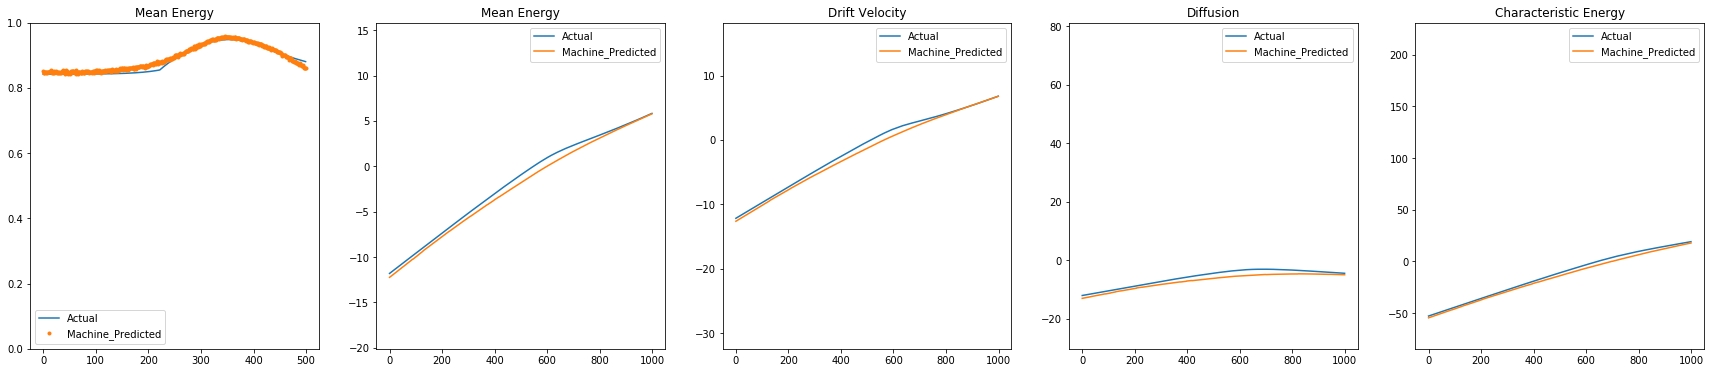

|(1000, 4)


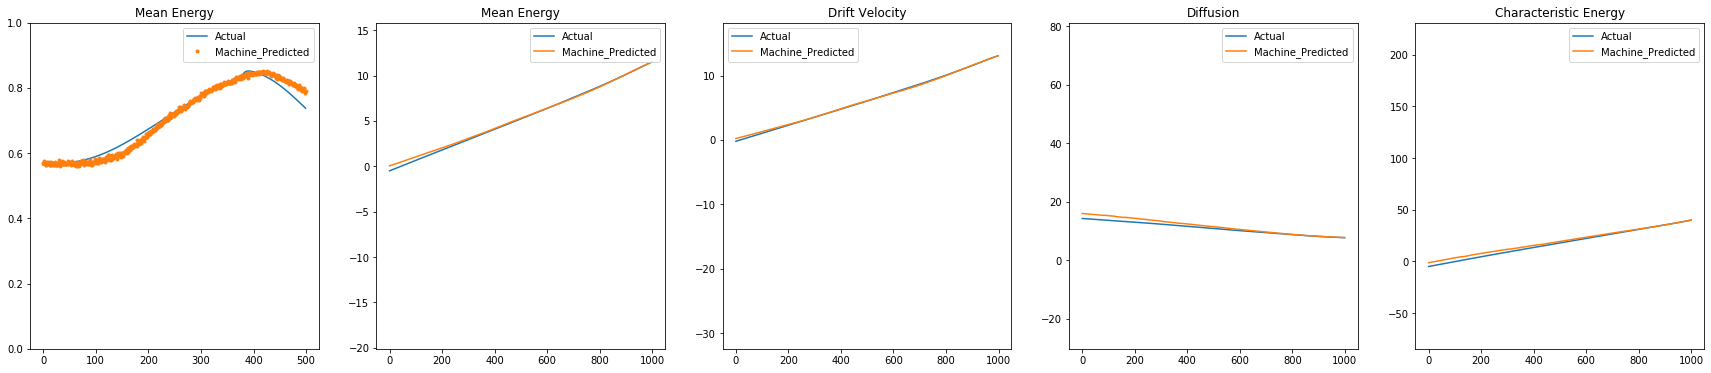

|(1000, 4)


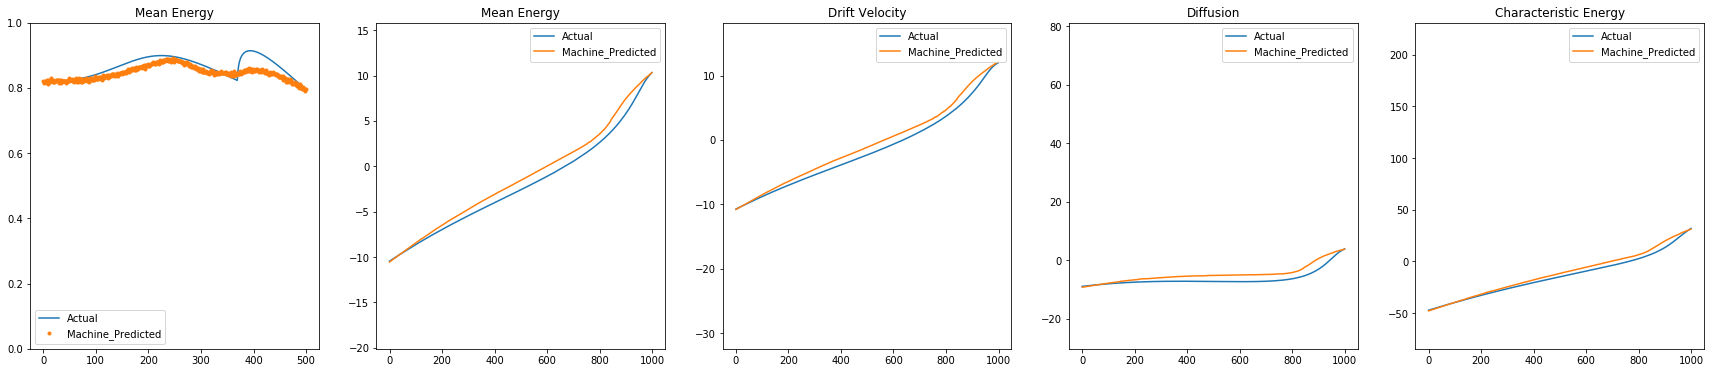

|(1000, 4)


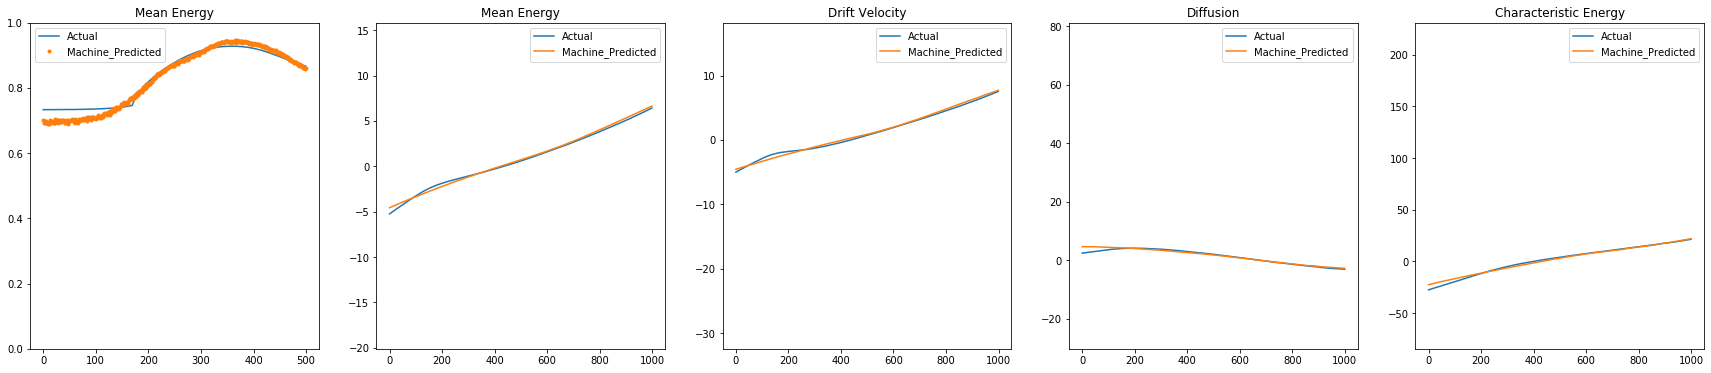

|(1000, 4)


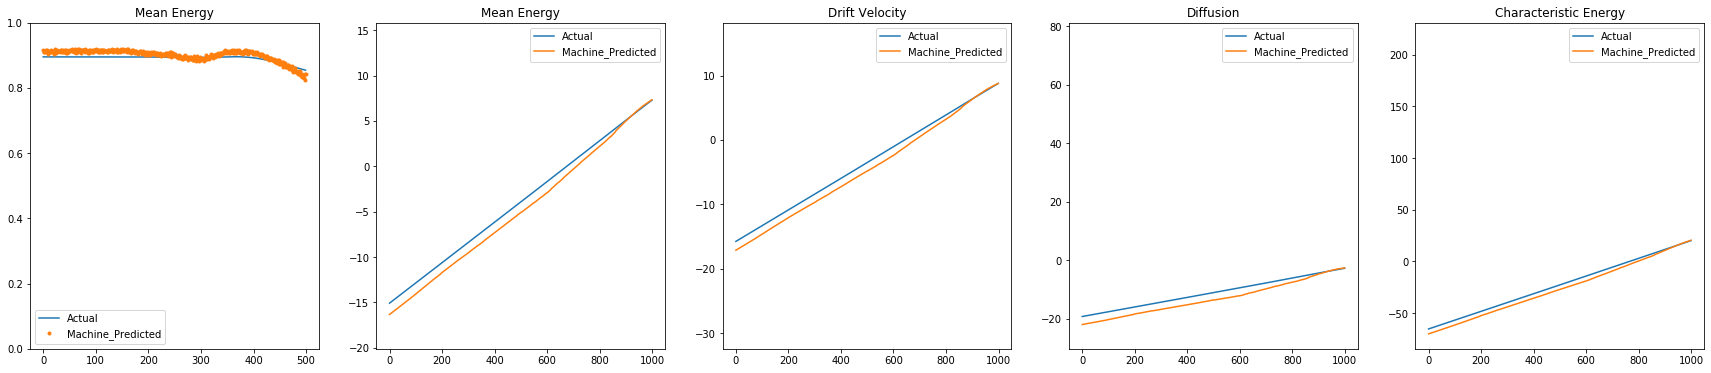

|(1000, 4)


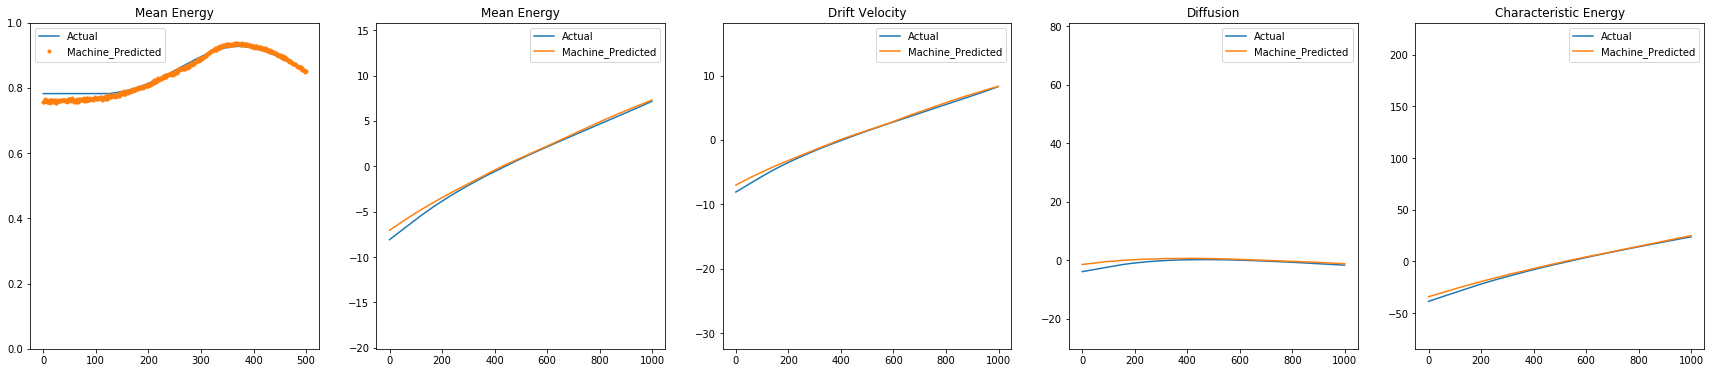

|(1000, 4)


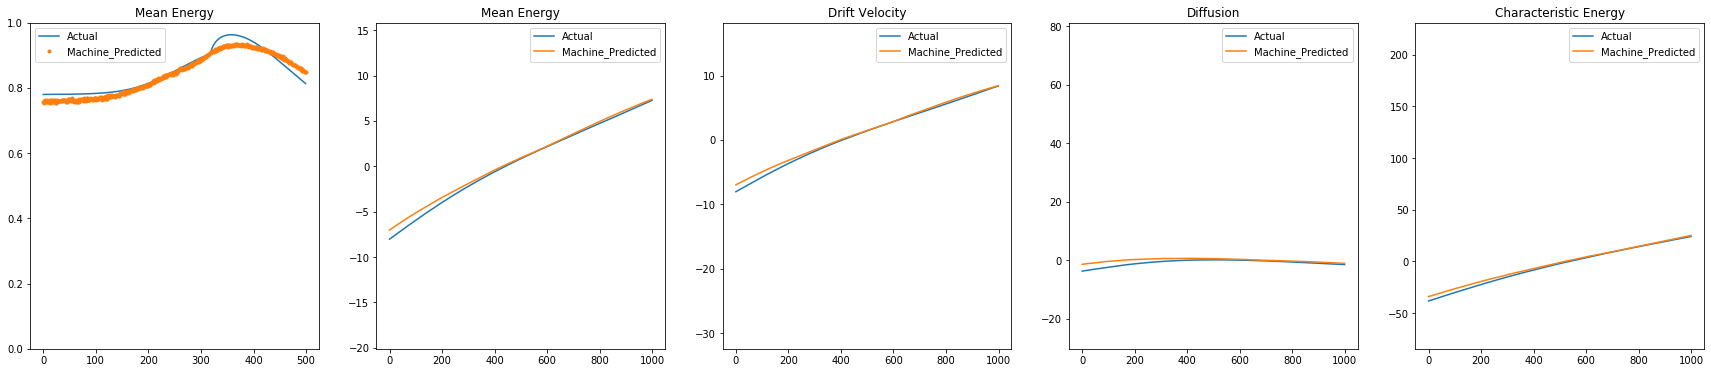

|(1000, 4)


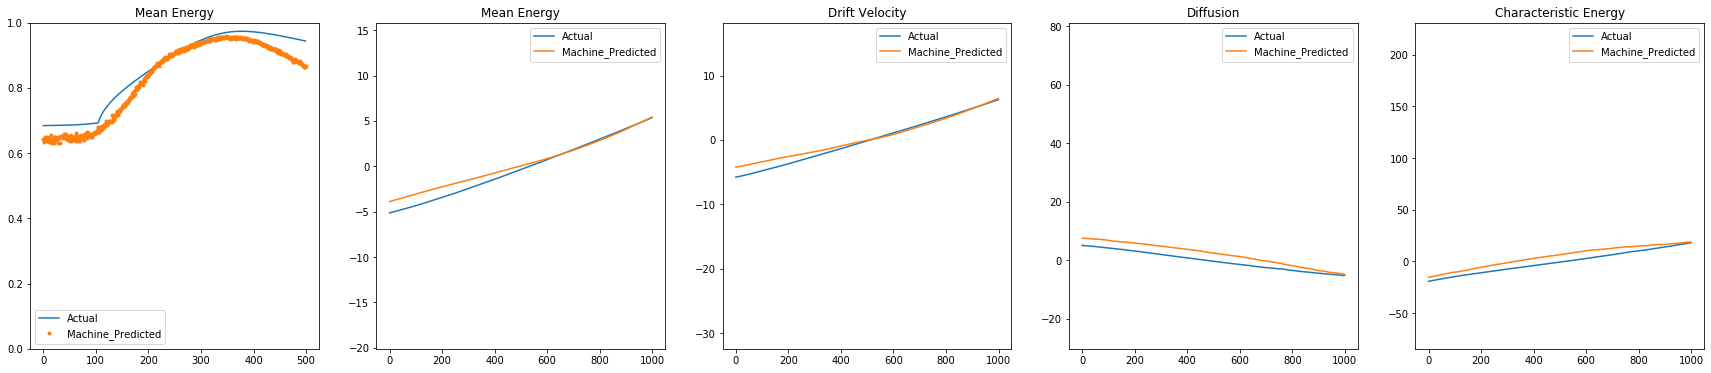

|(1000, 4)


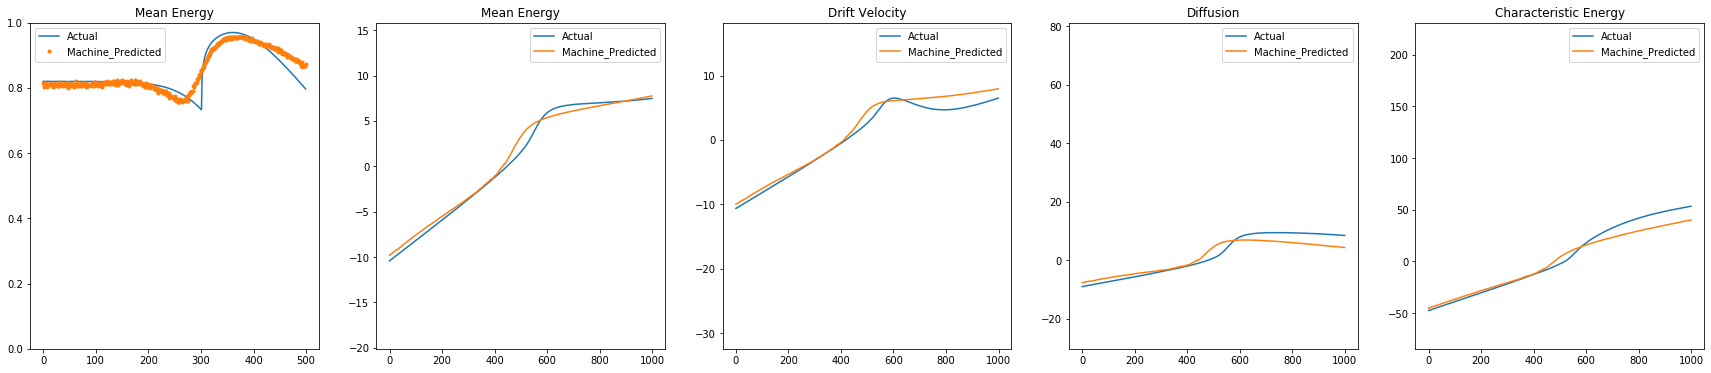

|(1000, 4)


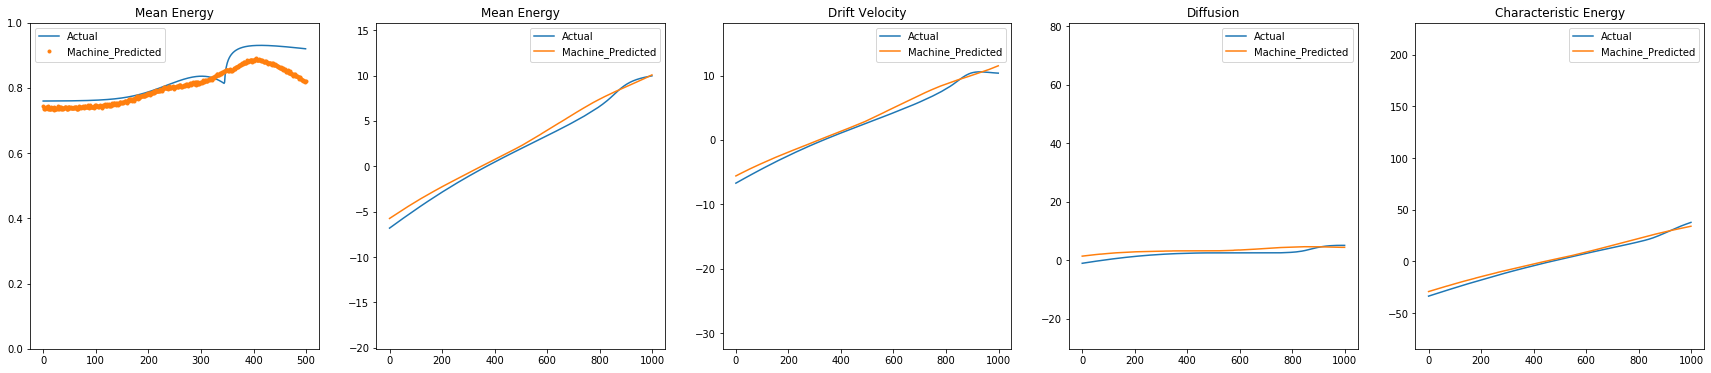

21.723222732543945


In [16]:
#Inverting normalisation of Predicted Y
y_pred=10**((y_hat*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(n):
    #plt.loglog(E,y_hat[i,:])
    bolsig.Input(E,y_pred[i,:])
    bolsig.ex(grid=100,n=1000,E_min=1e-3,E_max=10) #n cannot be more than 1000
    bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Normalisation trans to match X
    trans=np.reshape(trans,(-1,1000,4))
    for j in range(4):
        trans[:,:,j]=(trans[:,:,j]-x_mean[j])/x_std[j]
    
    fig, ax = plt.subplots(1, 5, figsize=(30,6))
    title=['Cross Section','Mean Energy',
           'Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].plot(Y[i,:])
    ax[0].plot(y_hat[i,:],'.')
    ax[0].legend(['Actual','Machine_Predicted'])
    ax[0].set_title(title[1])
    ax[0].set_ylim((0,1))
    for j in range(4):
        ax[j+1].plot(np.reshape(X[i,:],(1000,4))[:,j])
        ax[j+1].plot(trans[0,:,j])
        ax[j+1].legend(['Actual','Machine_Predicted'])
        ax[j+1].set_title(title[j+1])
        ax[j+1].set_ylim((np.min(np.reshape(X,(-1,1000,4))[:,:,j]),
                          np.max(np.reshape(X,(-1,1000,4))[:,:,j])))
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)